In [2]:
import xarray as xr
import torch
import numpy as np
import os
import json
import copy
import numpy as np
import shutil
from scipy.io import netcdf


from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid

'''

os.system("jupyter nbconvert --to script 'climate_train.ipynb'")
os.system("jupyter nbconvert --to script 'climate_data.ipynb'")
os.system("jupyter nbconvert --to script 'climate_models.ipynb'")
os.system("jupyter nbconvert --to script 'climate_job_maintenance.ipynb'")'''

import climate_train
import climate_data
import climate_models
import climate_job_maintenance as cjm

def longitude_average(R2):
    mr2=np.zeros((R2.shape[0],R2.shape[1]))
    sr2=np.zeros((R2.shape[0],R2.shape[1]))
    for t in range(R2.shape[0]*R2.shape[1]):
        i=t%R2.shape[0]
        j=t//R2.shape[0]
        rr=R2[i,j]
        rr=rr[rr>0]
        rr[rr>1]=1
        with np.errstate(divide='ignore'):
            if len(rr)>0:
                mr2[i,j]=np.mean(rr)
                sr2[i,j]=np.std(rr)
    return mr2,sr2
def longitude_full_average(R2):
    mr2=np.zeros(R2.shape[0])
    sr2=np.zeros(R2.shape[0])
    for t in range(R2.shape[0]):
        rr=R2[t]
        rr=rr[rr>0]
        rr[rr>1]=1
        with np.errstate(divide='ignore'):
            if len(rr)>0:
                mr2[t]=np.mean(rr)
                sr2[t]=np.std(rr)
    return mr2,sr2
def code2vals(num,C):
    T=[]
    for i in range(len(C)):
        T.append(num%C[i])
        num=num//C[i]
    return T

In [3]:
ls /scratch/zanna/data/cm2.6/

1pct-CO2-3D-data.zarr/                    coarse-3D-data-sigma-16.zarr/
1pct-CO2-surf-data.zarr/                  coarse-3D-data-sigma-4.zarr/
1pct_co2/                                 coarse-3D-data-sigma-6.zarr/
3D-data.zarr/                             coarse-3D-data-sigma-8.zarr/
coarse-1pct-CO2-3D-data-sigma-12.zarr/    coarse-surf-data-sigma-10.zarr/
coarse-1pct-CO2-3D-data-sigma-16.zarr/    coarse-surf-data-sigma-12.zarr/
coarse-1pct-CO2-3D-data-sigma-4.zarr/     coarse-surf-data-sigma-14.zarr/
coarse-1pct-CO2-3D-data-sigma-8.zarr/     coarse-surf-data-sigma-16.zarr/
coarse-1pct-CO2-surf-data-sigma-12.zarr/  coarse-surf-data-sigma-4.zarr/
coarse-1pct-CO2-surf-data-sigma-16.zarr/  coarse-surf-data-sigma-6.zarr/
coarse-1pct-CO2-surf-data-sigma-4.zarr/   coarse-surf-data-sigma-8.zarr/
coarse-1pct-CO2-surf-data-sigma-8.zarr/   geometry/
coarse-3D-data-sigma-10.zarr/             info.txt*
coarse-3D-data-sigma-12.zarr/             picontrol/
coarse-3D-data-sigma-14.zarr/             s

In [4]:
def get_area_fun(sigma):
    if sigma>0:
        dszarr=xr.open_zarr('/scratch/zanna/data/cm2.6/coarse-surf-data-sigma-'+str(sigma)+'.zarr')
    else:
        dszarr=xr.open_zarr('/scratch/zanna/data/cm2.6/surf-data.zarr')
    yu=dszarr.sel(yu_ocean=slice(-85,85)).yu_ocean.values
    xu=dszarr.sel(yu_ocean=slice(-85,85)).xu_ocean.values
    radius=6378.1
    dx=xu[1]-xu[0]
    dy=yu[1:]-yu[:-1]
    area=[]
    for i in range(len(yu)-1):
        y=yu[i]
        side_x=np.sin(np.pi*dx/180)*2*radius*np.sin(np.pi*(0.5-np.abs(y)/180))
        side_y=radius*np.sin(np.pi*(0.5-np.abs(y)/180))*dy[i]/180*np.pi
        area.append(side_x*side_y)
    area.append(area[-1])
    return yu,np.array(area)

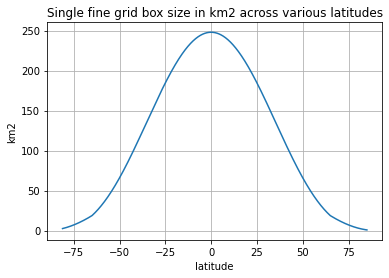

In [5]:
for sigma in [4]:
    yu,area=get_area_fun(0)
    I=np.argmin(np.abs(yu))
    '''yu=yu[:I]
    area=area[:I]'''
    plt.plot(yu,area)#,label='sigma='+str(sigma))
#plt.legend()
plt.ylabel('km2')
plt.xlabel('latitude')
plt.title('Single fine grid box size in km2 across various latitudes')
plt.grid('minor')

In [6]:
len(yu)

2581

In [7]:
# DATASET (2)
# SURF/DEEP 

# ARCHITECTURE (3)
# LCNN/QCNN/UNET

# SIGMAVALS (4)
# 4 8 12 16 

# GEOPHYS (3)
# NONE - GLOBAL - (GLOBAL+COORDS)

# RESIDUE TARGET(2)
# YES - NO

In [8]:
args=climate_train.options(string_input="-b 3".split())

In [9]:
args.model_id=8000
args.model_bank_id="G"

C,names=climate_models.golden_model_bank(args,only_description=True,verbose=True)

filter size training 8000
	dataset
		surf - depth 110m - 
	filter sozes
		21 - 15 - 9 - 7 - 5 - 4 - 3 - 2 - 1 - 
	sigma
		4 - 8 - 12 - 16 - 
	residue
		yes - no - 


In [10]:
offset=8000
x=[[0],np.arange(9).tolist(),[0],[0]]
J=cjm.jobnums(C=C,x=x,offset=offset)

In [11]:
J

[8000, 8002, 8004, 8006, 8008, 8010, 8012, 8014, 8016]

In [13]:
raw_data_address='/scratch/zanna/data/cm2.6/coarse-3D-data-sigma-4.zarr'
ds_zarr=xr.open_zarr(raw_data_address)

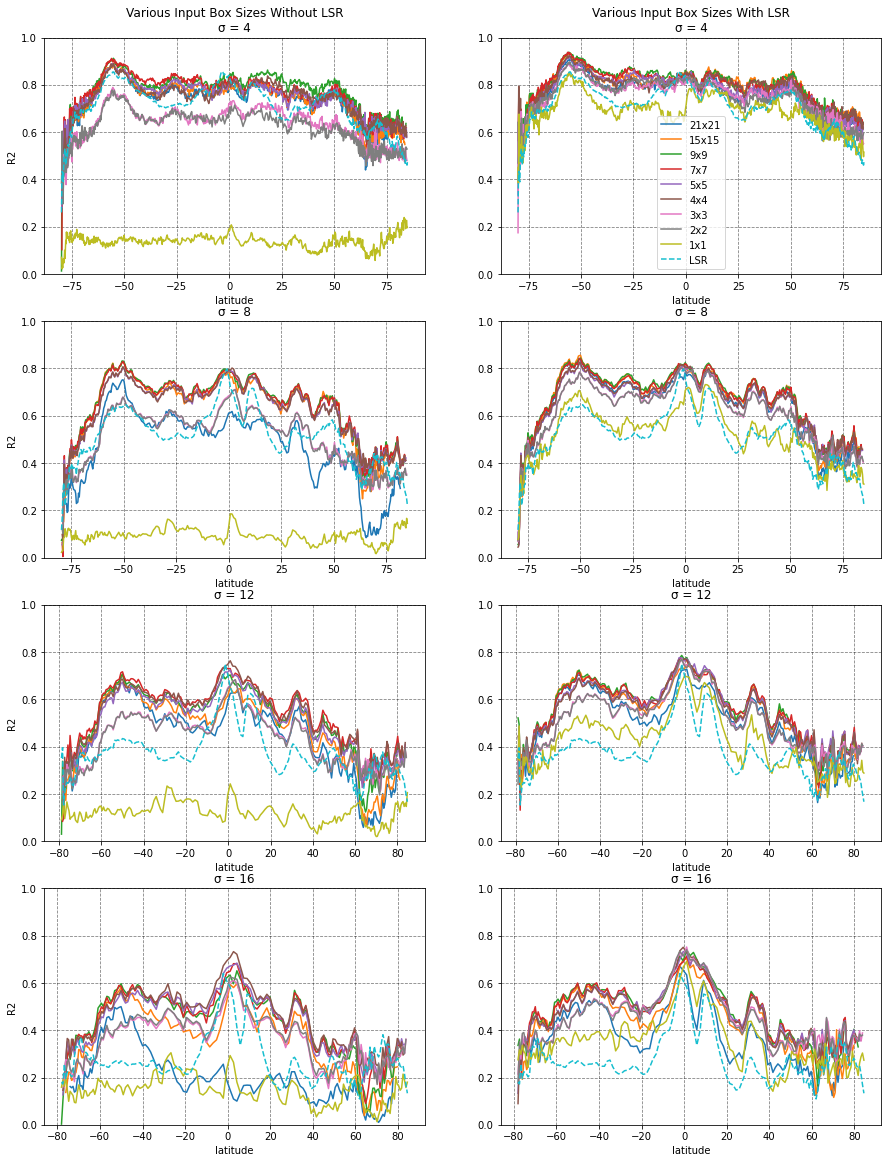

In [32]:
ncols=2
sigmas=[4,8,12,16]
fig,axs=plt.subplots(len(sigmas),ncols,figsize=(15,20))
fig.patch.set_facecolor('white')

for s in range(len(sigmas)):
    sigma=sigmas[s]
    datype=['Various Input Box Sizes Without LSR','Various Input Box Sizes With LSR']

    offset=8000

    x=[[0],np.arange(9).tolist(),[s],[1]]
    filt_sizes=[21,15,9,7,5,4,3,2,1]
    J=cjm.jobnums(C=C,x=x,offset=offset)

    lines=[str(i)+'x'+str(i) for i in filt_sizes]
    ranks=np.arange(9).tolist()
    coli=[0]*len(J)+[1]*len(J)

    x=[[0],np.arange(9).tolist(),[s],[0]]
    filt_sizes=[21,15,9,7,5,4,3,2,1]
    J+=cjm.jobnums(C=C,x=x,offset=offset)

    lines+=[str(i)+'x'+str(i) for i in filt_sizes]#[str(i)+'x'+str(i)+' + PKP' for i in filt_sizes]
    ranks+=(ranks[-1]+1+np.arange(9)).tolist()

    box=filt_sizes*2

    yu,area=get_area_fun(sigma)
    r2_mean=[[],[]]
    r2_std=[[],[]]
    r2_mean_pkp=[[],[]]
    r2_std_pkp=[[],[]]
    for k in range(len(J)):
        j=coli[k]
        ax=axs[s,j]
        root='/scratch/cg3306/climate/runs/'
        readfile=True
        foldername='G-'+str(J[k])
        try:
            with np.errstate(divide='ignore'):
                MSE=np.load(root+foldername+'/MSE.npy')
                SC2=np.load(root+foldername+'/SC2.npy')
        except:
            readfile=False
        if readfile:
            if len(MSE.shape)>3:
                MSE=MSE[0]
                SC2=SC2[0]
            Z=SC2*1
            Z[Z==0]=np.nan
            R2=1-np.sum(MSE,axis=0)/np.sum(Z,axis=0)

            Z=R2[R2==R2]
            Z=Z[Z>0]
            Z[Z>1]=1
            r2_mean[j].append(np.mean(Z))
            r2_std[j].append(np.std(Z))

            r2=np.zeros(R2.shape[0])
            for i in range(R2.shape[0]):
                zz=R2[i]*1
                zz=zz[zz>0]
                zz[zz>1]=1
                if len(zz)>0:
                    r2[i]=np.mean(zz)
                else:
                    r2[i]=np.nan

            cut=(len(yu)-len(r2))//2
            if cut>0:
                yu_=yu[cut:-cut]
            else:
                yu_=yu*1
            ax.plot(yu_,r2,label=lines[ranks[k]])

    for j in range(2):
        ax=axs[s,j]
        '''ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        if j==1:
            ax2.set_ylabel('km2', color=color)  # we already handled the x-label with ax1
        ax2.plot(yu, area*16, color=color,linestyle='--',label='1x1 grid box size in km2')
        ax2.tick_params(axis='y', labelcolor=color)
        if j==0:
            ax2.legend()'''

        MSELOC='/scratch/cg3306/climate/projection_analysis/surf-data-sigma-'+str(sigma)+'MSE.npy'
        SC2LOC=MSELOC.replace('MSE','SC2')
        with np.errstate(divide='ignore'):
            MSE=np.load(MSELOC)
            SC2=np.load(SC2LOC)
        Z=SC2*1
        Z[Z==0]=np.nan
        R2=1-np.sum(MSE,axis=0)/np.sum(Z,axis=0)


        Z=R2[R2==R2]
        Z=Z[Z>0]
        Z[Z>1]=1
        r2_mean_pkp[j]=np.mean(Z)
        r2_std_pkp[j]=np.std(Z)

        r2=np.zeros(R2.shape[0])
        for i in range(R2.shape[0]):
            zz=R2[i]*1
            zz=zz[zz>0]
            zz[zz>1]=1
            if len(zz)>0:
                r2[i]=np.mean(zz)
            else:
                r2[i]=np.nan

        cut=(len(yu)-len(r2))//2
        if cut>0:
            yu_=yu[cut:-cut]
        else:
            yu_=yu*1


        ax.plot(yu_,r2,label='LSR',linestyle='--')

        if j==0:
            ax.set_ylabel('R2')
        ax.set_xlabel('latitude')
        
        title=''
        if s==0:
            title=datype[j]+'\n'
        title+='\u03C3 = '+str(sigma)
        ax.set_title(title)
        if j==1 and s==0:
            ax.legend()
        ax.grid(color='k',linestyle='--',alpha=0.5)

        ax.set_ylim([0,1])

Text(0.5, 0.98, 'Average and Standard Deviation of R2 Values')

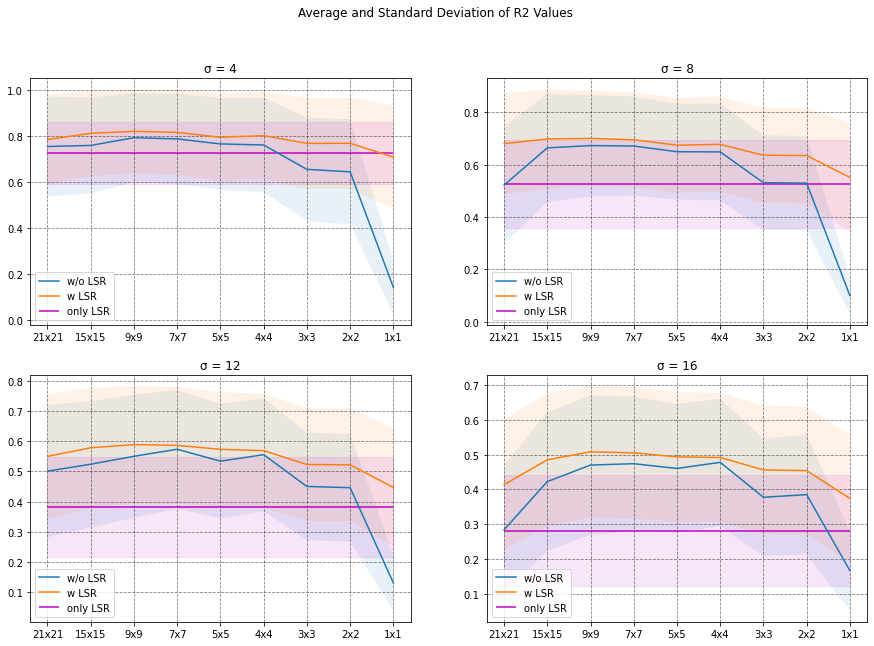

In [27]:
ncols=2
sigmas=[4,8,12,16]
fig,axs=plt.subplots(2,2,figsize=(15,10))
fig.patch.set_facecolor('white')

for s in range(len(sigmas)):
    sigma=sigmas[s]
    datype=['Various Input Box Sizes Without LSR','Various Input Box Sizes With LSR']

    offset=8000

    x=[[0],np.arange(9).tolist(),[s],[1]]
    filt_sizes=[21,15,9,7,5,4,3,2,1]
    J=cjm.jobnums(C=C,x=x,offset=offset)

    lines=[str(i)+'x'+str(i) for i in filt_sizes]
    ranks=np.arange(9).tolist()
    coli=[0]*len(J)+[1]*len(J)

    x=[[0],np.arange(9).tolist(),[s],[0]]
    filt_sizes=[21,15,9,7,5,4,3,2,1]
    J+=cjm.jobnums(C=C,x=x,offset=offset)

    lines+=[str(i)+'x'+str(i) for i in filt_sizes]#[str(i)+'x'+str(i)+' + PKP' for i in filt_sizes]
    ranks+=(ranks[-1]+1+np.arange(9)).tolist()

    box=filt_sizes*2

    yu,area=get_area_fun(sigma)
    r2_mean=[[],[]]
    r2_std=[[],[]]
    r2_mean_pkp=[[],[]]
    r2_std_pkp=[[],[]]
    for k in range(len(J)):
        j=coli[k]
        root='/scratch/cg3306/climate/runs/'
        readfile=True
        foldername='G-'+str(J[k])
        try:
            with np.errstate(divide='ignore'):
                MSE=np.load(root+foldername+'/MSE.npy')
                SC2=np.load(root+foldername+'/SC2.npy')
        except:
            readfile=False
        if readfile:
            if len(MSE.shape)>3:
                MSE=MSE[0]
                SC2=SC2[0]
            Z=SC2*1
            Z[Z==0]=np.nan
            R2=1-np.sum(MSE,axis=0)/np.sum(Z,axis=0)

            Z=R2[R2==R2]
            Z=Z[Z>0]
            Z[Z>1]=1
            r2_mean[j].append(np.mean(Z))
            r2_std[j].append(np.std(Z))

            r2=np.zeros(R2.shape[0])
            for i in range(R2.shape[0]):
                zz=R2[i]*1
                zz=zz[zz>0]
                zz[zz>1]=1
                if len(zz)>0:
                    r2[i]=np.mean(zz)
                else:
                    r2[i]=np.nan

            cut=(len(yu)-len(r2))//2
            if cut>0:
                yu_=yu[cut:-cut]
            else:
                yu_=yu*1
            #ax.plot(yu_,r2,label=lines[ranks[k]])

    for j in range(2):
        MSELOC='/scratch/cg3306/climate/projection_analysis/surf-data-sigma-'+str(sigma)+'MSE.npy'
        SC2LOC=MSELOC.replace('MSE','SC2')
        with np.errstate(divide='ignore'):
            MSE=np.load(MSELOC)
            SC2=np.load(SC2LOC)
        Z=SC2*1
        Z[Z==0]=np.nan
        R2=1-np.sum(MSE,axis=0)/np.sum(Z,axis=0)


        Z=R2[R2==R2]
        Z=Z[Z>0]
        Z[Z>1]=1
        r2_mean_pkp[j]=np.mean(Z)
        r2_std_pkp[j]=np.std(Z)

        r2=np.zeros(R2.shape[0])
        for i in range(R2.shape[0]):
            zz=R2[i]*1
            zz=zz[zz>0]
            zz[zz>1]=1
            if len(zz)>0:
                r2[i]=np.mean(zz)
            else:
                r2[i]=np.nan

        cut=(len(yu)-len(r2))//2
        if cut>0:
            yu_=yu[cut:-cut]
        else:
            yu_=yu*1



    r2_mean=[np.array(a) for a in r2_mean]
    r2_std=[np.array(a) for a in r2_std]
    
    #fig,ax=plt.subplots(1,1,figsize=(5,5))
    #fig.patch.set_facecolor('white')
    ax=axs[s//2,s%2]
    x=np.arange(len(r2_mean[0]))
    ax.plot(x,r2_mean[0],label='w/o LSR')
    ax.fill_between(x, r2_mean[0]-r2_std[0], r2_mean[0]+r2_std[0],alpha=0.1)
    ax.plot(x,r2_mean[1],label='w LSR')
    ax.fill_between(x,r2_mean[1]-r2_std[1], r2_mean[1]+r2_std[1],alpha=0.1)
    ax.set_xticks(x)
    ax.set_xticklabels(lines[:9])
    ax.hlines(y=r2_mean_pkp[0],xmin=0,xmax=8,color='m',label='only LSR')

    ax.fill_between(x,r2_mean_pkp[0]-r2_std_pkp[0], r2_mean_pkp[1]+r2_std_pkp[1],alpha=0.1,color='m')

    ax.legend(loc='lower left')
    ax.grid(color='k',linestyle='--',alpha=0.5)
    ax.set_title('\u03C3 = '+str(sigma))
fig.suptitle('Average and Standard Deviation of R2 Values')

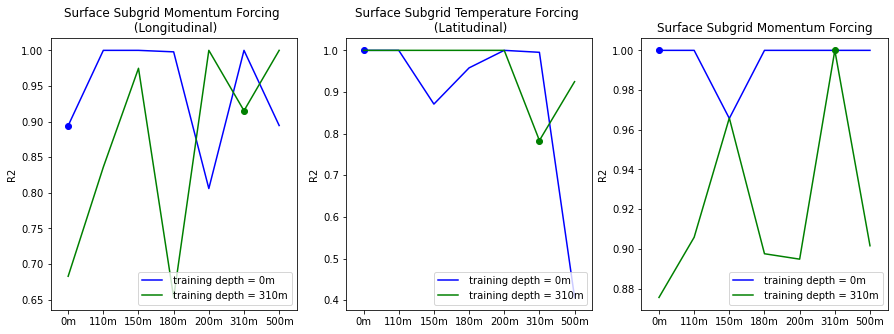

In [71]:
fig,axs=plt.subplots(1,3,figsize=(15,5))
fig.patch.set_facecolor('white')
depths=[0,110,150,180,200,310,500]
labels=[str(str(dd))+'m' for dd in depths]
datype=['Surface Subgrid Momentum Forcing \n (Longitudinal)','Surface Subgrid Temperature Forcing \n (Latitudinal)','Surface Subgrid Momentum Forcing']
modelnames=['']
trs=[0,5]
r2vals=np.minimum(1-np.random.randn(len(trs),len(modelnames),len(datype),len(depths))*0.2,1)
xtcks=np.arange(len(labels))
colors=['b','g','r','m']
for i in range(len(axs)):
    ax=axs[i]
    ax.set_xticks(xtcks)
    ax.set_xticklabels(labels)
    ax.set_xlim([-0.5,len(labels)-.5])
    ax.set_title(datype[i])
    for t in range(len(trs)):
        for j in range(len(modelnames)):
            ax.plot(r2vals[t,j,i],color=colors[t],label=modelnames[j]+' training depth = '+str(depths[trs[t]])+'m')
            ax.plot(xtcks[trs[t]],r2vals[t,j,i,trs[t]],'o',color=colors[t])
    ax.set_ylabel('R2')
    ax.legend(loc='lower right')

In [ ]:
'''args=options(string_input=\
